# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Graphlab Create

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = graphlab.SFrame('kc_house_data.gl/')

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1480899408.log


This non-commercial license of GraphLab Create for academic use is assigned to chnlds@gmail.com and will expire on March 16, 2017.


# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [4]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [23]:
print len(all_features)

17


In [25]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 0.585450     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 0.634285     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 0.684351     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 0.737158     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 0.787983     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 0.835120     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [26]:
# Quiz Answer 1
model_all.get('coefficients').print_rows(num_rows=18)
print 'non zeros', model.coefficients['value'].nnz()

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None |  274873.05595 |  None  |
|     bedrooms     |  None |      0.0      |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 8468.53108691 |  None  |
|   sqft_living    |  None | 24.4207209824 |  None  |
| sqft_living_sqrt |  None | 350.060553386 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 842.068034898 |  None  |
|    sqft_above    |  None | 20.0247224171 |  None  |
|  sqft_basement   |  None |

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [5]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [6]:
import numpy as np
def calculate_rss(model, data, target='price'):
    predictions = model.predict(data)
    errors = data[target] - predictions
    return (errors*errors).sum()

In [7]:
import numpy as np
result = []
for l1_penalty in np.logspace(1, 7, num=13):
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose=False,
                                              l2_penalty=0., l1_penalty=l1_penalty)
    rss = calculate_rss(model, validation, target='price')
    result +=[[l1_penalty, rss],]
    print 'l1 penalty={}, RSS={}'.format(l1_penalty, rss)

l1 penalty=10.0, RSS=6.25766285142e+14
l1 penalty=31.6227766017, RSS=6.25766285362e+14
l1 penalty=100.0, RSS=6.25766286058e+14
l1 penalty=316.227766017, RSS=6.25766288257e+14
l1 penalty=1000.0, RSS=6.25766295212e+14
l1 penalty=3162.27766017, RSS=6.25766317206e+14
l1 penalty=10000.0, RSS=6.25766386761e+14
l1 penalty=31622.7766017, RSS=6.25766606749e+14
l1 penalty=100000.0, RSS=6.25767302792e+14
l1 penalty=316227.766017, RSS=6.25769507644e+14
l1 penalty=1000000.0, RSS=6.25776517727e+14
l1 penalty=3162277.66017, RSS=6.25799062845e+14
l1 penalty=10000000.0, RSS=6.25883719085e+14


*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

In [10]:
# Quiz Answer 2
rst=np.asarray(result)
index = np.argmin(rst, axis=0)[1]
print rst[index,:]

[  1.00000000e+01   6.25766285e+14]


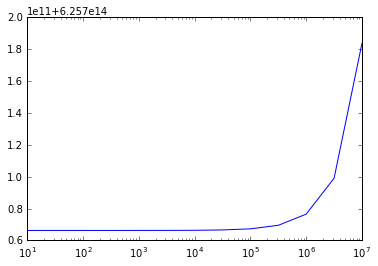

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = plt.subplot(111)
ax.set_xscale("log")
plt.plot(rst[:,0],rst[:,1],'-')

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [41]:
model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose=False,
                                              l2_penalty=0., l1_penalty=10)
print model.get('coefficients')
# Quiz Answer 3
print 'non zeros =', model.coefficients['value'].nnz()

+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |  18993.4272128   |  None  |
|     bedrooms     |  None |  7936.96767903   |  None  |
| bedrooms_square  |  None |  936.993368193   |  None  |
|    bathrooms     |  None |  25409.5889341   |  None  |
|   sqft_living    |  None |  39.1151363797   |  None  |
| sqft_living_sqrt |  None |  1124.65021281   |  None  |
|     sqft_lot     |  None | 0.00348361822299 |  None  |
|  sqft_lot_sqrt   |  None |  148.258391011   |  None  |
|      floors      |  None |   21204.335467   |  None  |
|  floors_square   |  None |  12915.5243361   |  None  |
+------------------+-------+------------------+--------+
[18 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
non zeros = 18


In [38]:
model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose=False,
                                              l2_penalty=0., l1_penalty=1e9)
print model.get('coefficients')

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None | 79529.8203017 |  None  |
|     bedrooms     |  None | 6348.31466221 |  None  |
| bedrooms_square  |  None | 31.0201101152 |  None  |
|    bathrooms     |  None | 23439.0612892 |  None  |
|   sqft_living    |  None | 38.0475711729 |  None  |
| sqft_living_sqrt |  None | 1038.65224566 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None | 72.3065508156 |  None  |
|      floors      |  None | 15907.5888998 |  None  |
|  floors_square   |  None | 8366.26612168 |  None  |
+------------------+-------+---------------+--------+
[18 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [12]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [13]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [14]:
result = []
for l1_penalty in np.logspace(8, 10, num=20):
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose=False,
                                              l2_penalty=0., l1_penalty=l1_penalty)
    rss = calculate_rss(model, validation, target='price')
    num_nonzeros = model.coefficients['value'].nnz()
    result +=[[l1_penalty, rss, num_nonzeros],]
    print 'l1 penalty={}, RSS={}, non-zeros={}'.format(l1_penalty, rss, num_nonzeros)


l1 penalty=100000000.0, RSS=6.27492659875e+14, non-zeros=18
l1 penalty=127427498.57, RSS=6.28210516771e+14, non-zeros=18
l1 penalty=162377673.919, RSS=6.29176689541e+14, non-zeros=18
l1 penalty=206913808.111, RSS=6.30650082719e+14, non-zeros=18
l1 penalty=263665089.873, RSS=6.32940229287e+14, non-zeros=17
l1 penalty=335981828.628, RSS=6.3626814023e+14, non-zeros=17
l1 penalty=428133239.872, RSS=6.41261198311e+14, non-zeros=17
l1 penalty=545559478.117, RSS=6.48983455376e+14, non-zeros=17
l1 penalty=695192796.178, RSS=6.60962217696e+14, non-zeros=17
l1 penalty=885866790.41, RSS=6.77261520728e+14, non-zeros=16
l1 penalty=1128837891.68, RSS=7.01046815867e+14, non-zeros=15
l1 penalty=1438449888.29, RSS=7.37850622829e+14, non-zeros=15
l1 penalty=1832980710.83, RSS=7.9616310964e+14, non-zeros=13
l1 penalty=2335721469.09, RSS=8.69018172894e+14, non-zeros=12
l1 penalty=2976351441.63, RSS=9.66925692362e+14, non-zeros=10
l1 penalty=3792690190.73, RSS=1.08186759232e+15, non-zeros=6
l1 penalty=4832

In [15]:
rst=np.array(result)
num_non0 = rst[:,2]

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [17]:
l1_penalty_min = 2976351441.63
l1_penalty_max = 3792690190.73

***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [18]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [19]:
result = []
for l1_penalty in l1_penalty_values:
    model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose=False,
                                              l2_penalty=0., l1_penalty=l1_penalty)
    rss = calculate_rss(model, validation, target='price')
    num_nonzeros = model.coefficients['value'].nnz()
    result +=[[l1_penalty, rss, num_nonzeros],]
    print 'l1 penalty={}, RSS={}, non-zeros={}'.format(l1_penalty, rss, num_nonzeros)

l1 penalty=2976351441.63, RSS=9.66925692362e+14, non-zeros=10
l1 penalty=3019316638.95, RSS=9.74019450085e+14, non-zeros=10
l1 penalty=3062281836.27, RSS=9.81188367942e+14, non-zeros=10
l1 penalty=3105247033.59, RSS=9.89328342459e+14, non-zeros=10
l1 penalty=3148212230.91, RSS=9.98783211266e+14, non-zeros=10
l1 penalty=3191177428.24, RSS=1.00847716702e+15, non-zeros=10
l1 penalty=3234142625.56, RSS=1.01829878055e+15, non-zeros=10
l1 penalty=3277107822.88, RSS=1.02824799221e+15, non-zeros=10
l1 penalty=3320073020.2, RSS=1.03461690923e+15, non-zeros=8
l1 penalty=3363038217.52, RSS=1.03855473594e+15, non-zeros=8
l1 penalty=3406003414.84, RSS=1.04323723787e+15, non-zeros=8
l1 penalty=3448968612.16, RSS=1.04693748875e+15, non-zeros=7
l1 penalty=3491933809.48, RSS=1.05114762561e+15, non-zeros=7
l1 penalty=3534899006.8, RSS=1.05599273534e+15, non-zeros=7
l1 penalty=3577864204.12, RSS=1.06079953176e+15, non-zeros=7
l1 penalty=3620829401.45, RSS=1.0657076895e+15, non-zeros=6
l1 penalty=36637945

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [20]:
# quiz answer 5
print 'l1 penalty=3448968612.16, RSS=1.04693748875e+15, non-zeros=7'

l1 penalty=3320073020.2, RSS=1.03461690923e+15, non-zeros=8


In [22]:
l1_penalty=3448968612.16
model = graphlab.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None, verbose=False,
                                              l2_penalty=0., l1_penalty=l1_penalty)
# Quiz Answer 6
print model.get('coefficients')

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None | 222253.192544 |  None  |
|     bedrooms     |  None | 661.722717782 |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 15873.9572593 |  None  |
|   sqft_living    |  None | 32.4102214513 |  None  |
| sqft_living_sqrt |  None | 690.114773313 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
+------------------+-------+---------------+--------+
[18 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
